# Forward modeling tutorial using mosaic images
## Fitting models

In this example I'll show you how to do some $\chi^2$ fitting to determine the age of a quiescent galaxy.

In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from sim_tools import *
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



## Create spectra object

In [2]:
sp = Gen_spec(1.255, 'beams/o195.0_21156.g102.A.fits','beams/o188.3_21156.g141.A.fits', 
              'galaxy_spec_g102.npy', 'galaxy_spec_g141.npy')
spMB = Gen_MB_spec('beams/gnd_21156.beams.fits', 1.255, 'galaxy_spec_g102.npy','galaxy_spec_g141.npy')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) >

1 flt_files/ib3721xiq_flt.fits G141
2 flt_files/ib3721xmq_flt.fits G141
3 flt_files/ib3721xyq_flt.fits G141
4 flt_files/ib3721y2q_flt.fits G141
5 flt_files/ib3725dyq_flt.fits G141
6 flt_files/ib3725e2q_flt.fits G141
7 flt_files/ib3725eeq_flt.fits G141
8 flt_files/ib3725eiq_flt.fits G141
9 flt_files/icat21cfq_flt.fits G102
10 flt_files/icat21coq_flt.fits G102
11 flt_files/icat21dgq_flt.fits G102
12 flt_files/icat21dlq_flt.fits G102
13 flt_files/icat25hcq_flt.fits G102
14 flt_files/icat25hiq_flt.fits G102
15 flt_files/icat25icq_flt.fits G102
16 flt_files/icat25iiq_flt.fits G102
17 flt_files/icxt51jvq_flt.fits G102
18 flt_files/icxt51jwq_flt.fits G102
19 flt_files/icxt51jzq_flt.fits G102
20 flt_files/icxt51k1q_flt.fits G102
21 flt_files/icxt52i0q_flt.fits G102
22 flt_files/icxt52i1q_flt.fits G102
23 flt_files/icxt52i4q_flt.fits G102
24 flt_files/icxt52i6q_flt.fits G102
25 flt_files/icxt53i9q_flt.fits G102
26 flt_files/icxt53iaq_flt.fits G102
27 flt_files/icxt53idq_flt.fits G102
28 flt_fil

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1354: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1359: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optim

In [3]:
# Age array in Gyrs
age = np.arange(1.0,6.5,0.5)

This function will return the $\chi^2$ value between the model and data

In [4]:
def Chi_Squared(data, model, error):
    return np.sum(((data-model) / error)**2)

Using the classes to generate the models, we can compare to both the g102 and g141 data.

In [5]:
chisq = np.zeros(age.size)
chisqmb = np.zeros(age.size)

for i in range(age.size):
    sp.Sim_spec('model_spec/m0.019_a{0}_dt8.0_spec.npy'.format(age[i]))
    spMB.Sim_spec('model_spec/m0.019_a{0}_dt8.0_spec.npy'.format(age[i]))
    
    chisq[i] = Chi_Squared(sp.gal_fl_102, sp.fl_102, sp.gal_er_102) + Chi_Squared(sp.gal_fl_141, sp.fl_141, sp.gal_er_141)
    chisqmb[i] = Chi_Squared(spMB.gal_fl_102, spMB.fl_102, spMB.gal_er_102) + Chi_Squared(spMB.gal_fl_141, spMB.fl_141, spMB.gal_er_141)

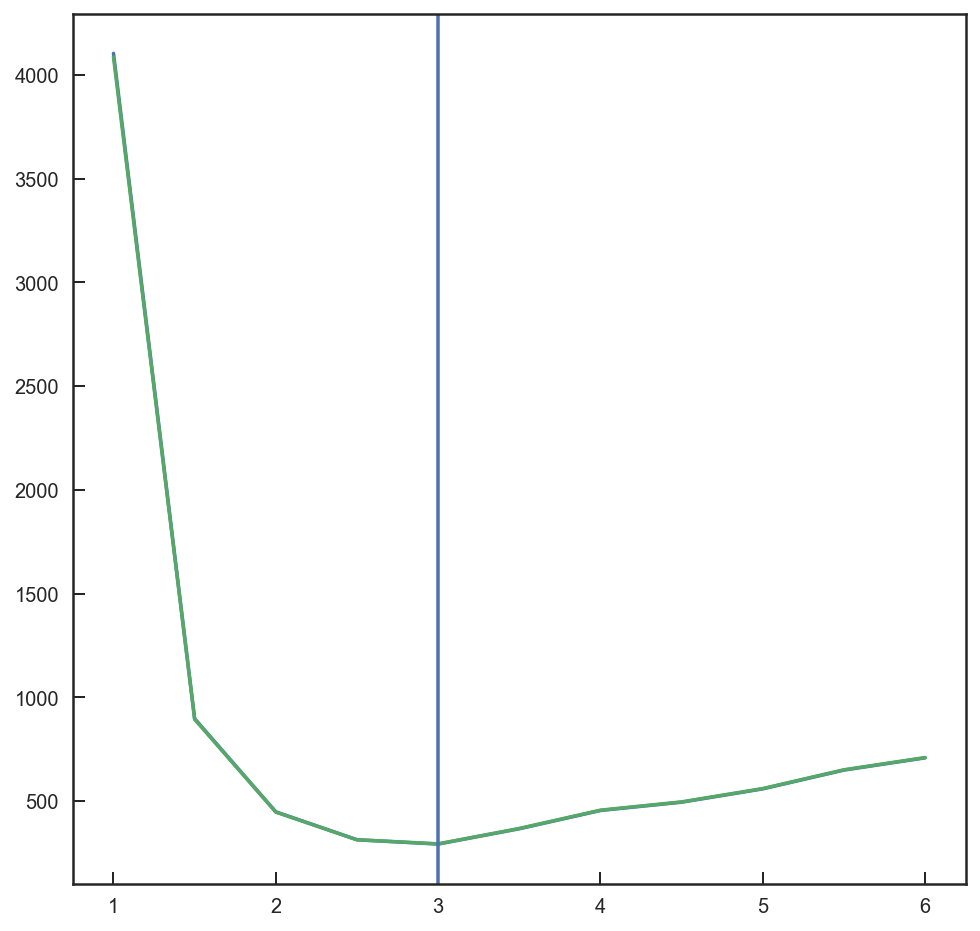

In [6]:
plt.figure(figsize=[8,8])
plt.plot(age,chisq)
plt.plot(age,chisqmb)
plt.axvline(age[chisq == min(chisq)])